In [3]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import tkinter as tk
from tkinter import filedialog
import pickle

In [17]:
def load_pickle_file(file_name):
    # ask the user to select the directory path to the pickle file
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askdirectory()

    # load the selected pickle file from the user provided file path
    if file_path:
        try:
            with open(file_path + '/' + file_name, 'rb') as f:
                my_dict = pickle.load(f)
                print("The keys of the dictionary are: " + str(my_dict.keys()))
        except FileNotFoundError:
            print("No pickle file found in the selected directory.")\
                
                
load_pickle_file('SpikeTrains_for_PSTHs.p')

The keys of the dictionary are: dict_keys(['Lmc_opsin_lmc_ch_1_3094_rec1_cid134_post_SpikeTrains_for_PSTHs', 'Lmc_opsin_lmc_ch_1_3094_rec2_cid113_post_SpikeTrains_for_PSTHs', 'Lmc_opsin_lmc_ch_1_3094_rec1_cid52_post_SpikeTrains_for_PSTHs', 'Lmc_opsin_lmc_ch_1_3094_rec1_cid238_pre_SpikeTrains_for_PSTHs', 'Lmc_opsin_lmc_ch_1_3094_rec1_cid148_pre_SpikeTrains_for_PSTHs', 'Lmc_noopsin_lmc_noch_1_3096_rec2_cid21_post_SpikeTrains_for_PSTHs', 'Lmc_opsin_lmc_ch_1_3094_rec2_cid113_pre_SpikeTrains_for_PSTHs', 'Lmc_opsin_lmc_ch_1_3094_rec1_cid145_post_SpikeTrains_for_PSTHs', 'Lmc_opsin_lmc_ch_1_3094_rec2_cid79_pre_SpikeTrains_for_PSTHs', 'Lmc_noopsin_lmc_noch_1_3096_rec1_cid24_post_SpikeTrains_for_PSTHs', 'Lmc_opsin_lmc_ch_1_3094_rec1_cid52_pre_SpikeTrains_for_PSTHs', 'Lmc_noopsin_lmc_noch_1_3096_rec2_cid219_pre_SpikeTrains_for_PSTHs', 'Lmc_opsin_lmc_ch_1_3094_rec2_cid82_post_SpikeTrains_for_PSTHs', 'Lmc_noopsin_lmc_noch_1_3096_rec2_cid211_post_SpikeTrains_for_PSTHs', 'Lmc_opsin_lmc_ch_1_3094_rec1

In [37]:
#directory of mat file
mat_dir_post = '/Users/cresp1el/Documents/lmc_project_analysis_dir/cell93_post_spiketrains.mat'
mat_dir_pre = '/Users/cresp1el/Documents/lmc_project_analysis_dir/cell93_pre_spiketrains.mat'

#create a dictionary to store the data
mat_post = scipy.io.loadmat(mat_dir_post)
mat_pre = scipy.io.loadmat(mat_dir_pre)


In [38]:
#store the data in a 'spiketrains_pre and spiketrains_post' variable
spiketrains_pre = mat_pre['cell93_pre_spiketrains']
spiketrains_post = mat_post['cell93_post_spiketrains']

In [39]:
#make a function to store the pre and post spike matrices into a dict where the keys are the stimulus frequencies
def spiketrains_dict(spiketrains_pre, spiketrains_post):
    spiketrains_dict = {}
    spiketrains_dict['pre_zero'] = spiketrains_pre[0,0]
    spiketrains_dict['pre_low'] = spiketrains_pre[0,1]
    spiketrains_dict['pre_mid'] = spiketrains_pre[0,2]
    spiketrains_dict['pre_high'] = spiketrains_pre[0,3]
    spiketrains_dict['post_zero'] = spiketrains_post[0,0]
    spiketrains_dict['post_low'] = spiketrains_post[0,1]
    spiketrains_dict['post_mid'] = spiketrains_post[0,2]
    spiketrains_dict['post_high'] = spiketrains_post[0,3]
    return spiketrains_dict

#call the function to create the dictionarys
spiketrains_dict = spiketrains_dict(spiketrains_pre, spiketrains_post)

In [107]:
#make a function that will loop through thr dictionary keys and create a dataframe per key and append it the to the dataframe 

def spiketrains_df(spiketrains_dict):
    #first loop through the the keys in the dictionary and create a dataframe for each key at the end of the loop append the dataframe to the main dataframe

    #create an empty dataframe called main_df
    main_df = pd.DataFrame()
    
    #create a list of column names that will be used for the main dataframe column names
    column_names = ['trial_name','trial_id','spikes', 'zero','low','mid','high']

    
    
    #loop through the keys in the dictionary
    #for each key determine the numbner of trials which is the number of rows of the matrix
    #then loop through the number of rows, create the trial_id which is the row number, add the row number to the trial_number column
    #then pull out the row slice of the matrix and add it to the corresponding spikes column
    #then add the trial name to the trial_name column
    
    for key in spiketrains_dict:
        
        #determine the number of trials which is the number of rows of the matrix
        num_trials = spiketrains_dict[key].shape[0]
        
        #iterate through the number of trials of the matrix and pull out the row slice of the matrix, store the row number as the trial_id in the main_df
        for trial in range(num_trials):
                
                #create a dataframe for each trial
                trial_df = pd.DataFrame()
                
                #add the trial_id to the trial_id column
                trial_df['trial_id'] = [trial]
                
                #add the spikes to the spikes column, pull out the row slice of the matrix
                trial_df['spikes'] = [spiketrains_dict[key][trial,:]]
                
                #add the trial name to the trial_name column
                trial_df['trial_name'] = [key]
                
                #check if the trial name is pre or post and TRUE in the column 'is_post'
                if 'post' in key:
                    trial_df['is_post'] = True
                else:
                    trial_df['is_post'] = False
                    
                #check if the trial name is zero, low, mid, or high and TRUE in the corresponding columnm if not FALSE
                if 'zero' in key:
                    trial_df['zero'] = True
                    trial_df['low'] = False
                    trial_df['mid'] = False
                    trial_df['high'] = False
                elif 'low' in key:
                    trial_df['zero'] = False
                    trial_df['low'] = True
                    trial_df['mid'] = False
                    trial_df['high'] = False
                elif 'mid' in key:
                    trial_df['zero'] = False
                    trial_df['low'] = False
                    trial_df['mid'] = True
                    trial_df['high'] = False
                elif 'high' in key:
                    trial_df['zero'] = False
                    trial_df['low'] = False
                    trial_df['mid'] = False
                    trial_df['high'] = True
                    
                #check if there are at least 2 spikes in the trial, if there are more than 2 spike then TRUE in the column 'more_than_2' or FALSE if there are less than 2 spikes
                if np.sum(spiketrains_dict[key][trial,:]) > 2:
                    trial_df['more_than_2'] = True
                else:
                    trial_df['more_than_2'] = False        
                    
                    
                #check if there are more than 50 spikes in the trial, if there are more than 50 spikes then TRUE in the column 'more_than_50' or FALSE if there are less than 50 spikes
                if np.sum(spiketrains_dict[key][trial,:]) > 50:
                    trial_df['more_than_50'] = True
                else:
                    trial_df['more_than_50'] = False
                
                #append the trial_df to the main_df
                main_df = main_df.append(trial_df)
                
    #reset the index of the main_df
    main_df = main_df.reset_index(drop=True)
    
        
    return main_df

#call the function to create the dataframe
main_df = spiketrains_df(spiketrains_dict)
    
#now         

/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/1802610028.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  main_df = main_df.append(trial_df)
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/1802610028.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  main_df = main_df.append(trial_df)
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/1802610028.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  main_df = main_df.append(trial_df)
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/1802610028.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  main_df = main_df.appen

In [25]:
#make a function to calculate the mean firing rate for each stimulus frequency from dict of spike matrices and return a dict of mean firing rates where the keys are the stimulus frequencies
def mean_firing_rate_dict(spiketrains_dict):
    mean_firing_rate_dict = {}
    for key in spiketrains_dict:
        mean_firing_rate_dict[key] = np.mean(spiketrains_dict[key], axis=0)*1000 #multiply by 1000 to convert to Hz
    return mean_firing_rate_dict

#call the function to create the dictionary of mean firing rates
mean_firing_rate_dict = mean_firing_rate_dict(spiketrains_dict)


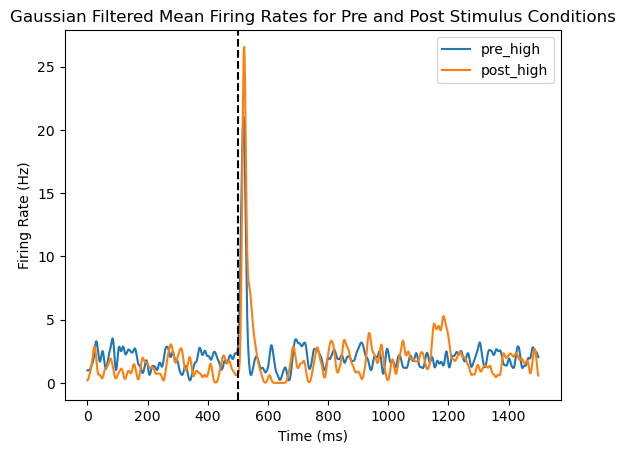

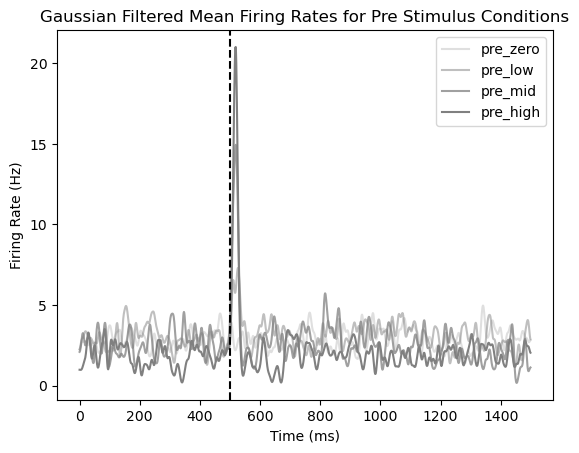

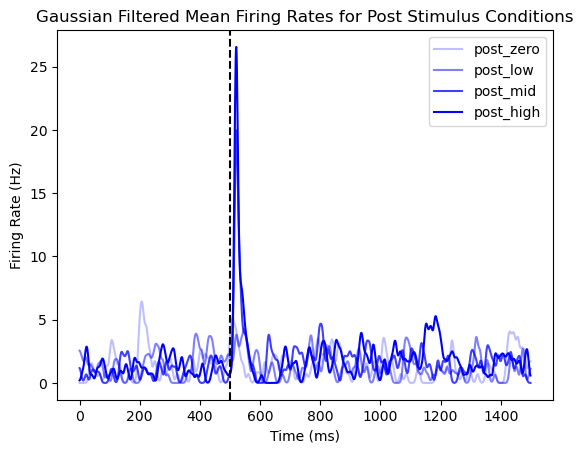

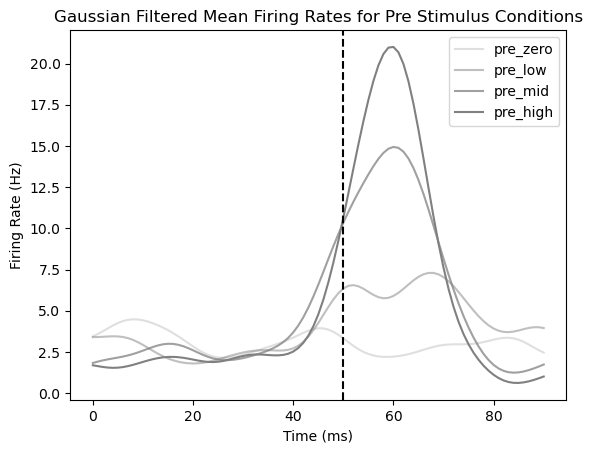

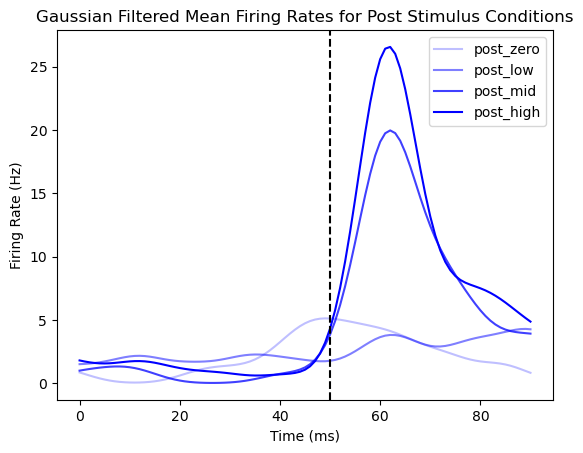

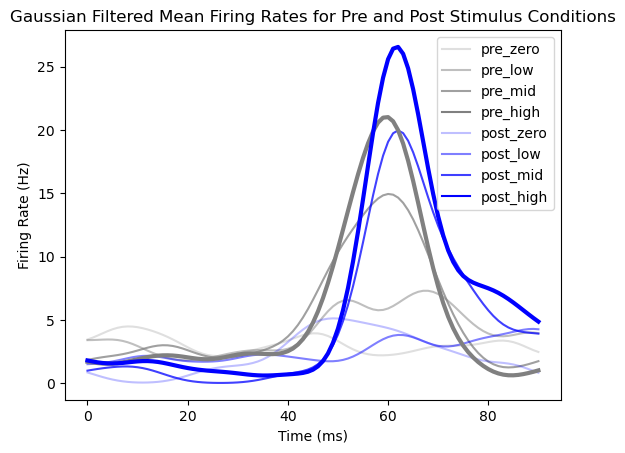

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Gaussian Filtered Mean Firing Rates for Pre and Post Stimulus Conditions'}, xlabel='Time (ms)', ylabel='Firing Rate (Hz)'>)

In [26]:
#gaussian filter the mean firing rates with user defined sigma and return a dict of gaussian filtered mean firing rates where the keys are the stimulus frequencies

from scipy.ndimage import gaussian_filter

#create a function to gaussian filter the mean firing rates with user defined sigma and return a dict of gaussian filtered mean firing rates where the keys are the stimulus frequencies
def gaussian_filter_dict(mean_firing_rate_dict, sigma):
    gaussian_filter_dict = {}
    for key in mean_firing_rate_dict:
        gaussian_filter_dict[key] = gaussian_filter(mean_firing_rate_dict[key], sigma=sigma)
    return gaussian_filter_dict

#call the function to create the dictionary of gaussian filtered mean firing rates
gaussian_filter_dict = gaussian_filter_dict(mean_firing_rate_dict, sigma=5)


#plot the gaussian filtered mean firing rates for the pre and post stimulus conditions on the same plot
def plot_gaussian_filter_dict(gaussian_filter_dict):
    fig, ax = plt.subplots(1,1)
    ax.plot(gaussian_filter_dict['pre_high'], label='pre_high')
    ax.plot(gaussian_filter_dict['post_high'], label='post_high')
    ax.legend()
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Gaussian Filtered Mean Firing Rates for Pre and Post Stimulus Conditions')
    
    #add vertical lines to indicate the stimulus onset and offset times 
    ax.axvline(x=500, color='black', linestyle='--')
    
    plt.show()
    return fig, ax

#call the function to plot the gaussian filtered mean firing rates for the pre and post stimulus conditions on the same plot
plot_gaussian_filter_dict(gaussian_filter_dict)

#plot the gaussian filtered mean firing rates for all prestimulus conditions on the same plot with increasing opacity for increasing stimuli
# keep the color the same for all prestimulus conditions and change the opacity for each stimulus condition
def plot_gaussian_filter_dict_all(gaussian_filter_dict):
    fig, ax = plt.subplots(1,1)
    ax.plot(gaussian_filter_dict['pre_zero'], color='grey', alpha=0.25, label='pre_zero')
    ax.plot(gaussian_filter_dict['pre_low'], color='grey', alpha=0.5, label='pre_low')
    ax.plot(gaussian_filter_dict['pre_mid'], color='grey', alpha=0.75, label='pre_mid')
    ax.plot(gaussian_filter_dict['pre_high'], color='grey', alpha=1, label='pre_high')
    ax.legend()
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Gaussian Filtered Mean Firing Rates for Pre Stimulus Conditions')
    
    #add vertical lines to indicate the stimulus onset and offset times 
    ax.axvline(x=500, color='black', linestyle='--')
    
    plt.show()
    return fig, ax

#call the function to plot the gaussian filtered mean firing rates for all prestimulus conditions on the same plot with increasing opacity for increasing stimuli
plot_gaussian_filter_dict_all(gaussian_filter_dict)


#now repeat the above for the post stimulus conditions
#plot the gaussian filtered mean firing rates for all poststimulus conditions on the same plot with increasing opacity for increasing stimuli
# keep the color the same for all poststimulus conditions and change the opacity for each stimulus condition
def plot_gaussian_filter_dict_all_post(gaussian_filter_dict):
    fig, ax = plt.subplots(1,1)
    ax.plot(gaussian_filter_dict['post_zero'], color='blue', alpha=0.25, label='post_zero')
    ax.plot(gaussian_filter_dict['post_low'], color='blue', alpha=0.5, label='post_low')
    ax.plot(gaussian_filter_dict['post_mid'], color='blue', alpha=0.75, label='post_mid')
    ax.plot(gaussian_filter_dict['post_high'], color='blue', alpha=1, label='post_high')
    ax.legend()
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Gaussian Filtered Mean Firing Rates for Post Stimulus Conditions')
    
    #add vertical lines to indicate the stimulus onset and offset times 
    ax.axvline(x=500, color='black', linestyle='--')
    
    plt.show()
    return fig, ax

#call the function to plot the gaussian filtered mean firing rates for all poststimulus conditions on the same plot with increasing opacity for increasing stimuli
plot_gaussian_filter_dict_all_post(gaussian_filter_dict)

#now the same but zoom in from 459 to 550 ms
#plot the gaussian filtered mean firing rates for all prestimulus conditions on the same plot with increasing opacity for increasing stimuli
# keep the color the same for all prestimulus conditions and change the opacity for each stimulus condition
def plot_gaussian_filter_dict_all_zoom(gaussian_filter_dict):
    fig, ax = plt.subplots(1,1)
    ax.plot(gaussian_filter_dict['pre_zero'][459:550], color='grey', alpha=0.25, label='pre_zero')
    ax.plot(gaussian_filter_dict['pre_low'][459:550], color='grey', alpha=0.5, label='pre_low')
    ax.plot(gaussian_filter_dict['pre_mid'][459:550], color='grey', alpha=0.75, label='pre_mid')
    ax.plot(gaussian_filter_dict['pre_high'][459:550], color='grey', alpha=1, label='pre_high')
    ax.legend()
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Gaussian Filtered Mean Firing Rates for Pre Stimulus Conditions')
        #add vertical lines to indicate the stimulus onset and offset times 
    ax.axvline(x=50, color='black', linestyle='--')
    plt.show()
    return fig, ax

#call the function to plot the gaussian filtered mean firing rates for all prestimulus conditions on the same plot with increasing opacity for increasing stimuli
plot_gaussian_filter_dict_all_zoom(gaussian_filter_dict)

#now repeat this plot for the post stimulus conditions
#plot the gaussian filtered mean firing rates for all poststimulus conditions on the same plot with increasing opacity for increasing stimuli
# keep the color the same for all poststimulus conditions and change the opacity for each stimulus condition
def plot_gaussian_filter_dict_all_post_zoom(gaussian_filter_dict):
    fig, ax = plt.subplots(1,1)
    ax.plot(gaussian_filter_dict['post_zero'][459:550], color='blue', alpha=0.25, label='post_zero')
    ax.plot(gaussian_filter_dict['post_low'][459:550], color='blue', alpha=0.5, label='post_low')
    ax.plot(gaussian_filter_dict['post_mid'][459:550], color='blue', alpha=0.75, label='post_mid')
    ax.plot(gaussian_filter_dict['post_high'][459:550], color='blue', alpha=1, label='post_high')
    ax.legend()
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Gaussian Filtered Mean Firing Rates for Post Stimulus Conditions')
    ax.axvline(x=50, color='black', linestyle='--') 
    plt.show()
    return fig, ax

#call the function to plot the gaussian filtered mean firing rates for all poststimulus conditions on the same plot with increasing opacity for increasing stimuli
plot_gaussian_filter_dict_all_post_zoom(gaussian_filter_dict)


#now over lay the zoomed in pre and post stimulus conditions on the same plot

def plot_gaussian_filter_dict_all_zoom_overlay(gaussian_filter_dict):
    fig, ax = plt.subplots(1,1)
    ax.plot(gaussian_filter_dict['pre_zero'][459:550], color='grey', alpha=0.25, label='pre_zero')
    ax.plot(gaussian_filter_dict['pre_low'][459:550], color='grey', alpha=0.5, label='pre_low')
    ax.plot(gaussian_filter_dict['pre_mid'][459:550], color='grey', alpha=0.75, label='pre_mid')
    ax.plot(gaussian_filter_dict['pre_high'][459:550], color='grey', alpha=1, label='pre_high')
    ax.plot(gaussian_filter_dict['post_zero'][459:550], color='blue', alpha=0.25, label='post_zero')
    ax.plot(gaussian_filter_dict['post_low'][459:550], color='blue', alpha=0.5, label='post_low')
    ax.plot(gaussian_filter_dict['post_mid'][459:550], color='blue', alpha=0.75, label='post_mid')
    ax.plot(gaussian_filter_dict['post_high'][459:550], color='blue', alpha=1, label='post_high')
    ax.legend()
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Gaussian Filtered Mean Firing Rates for Pre and Post Stimulus Conditions')
    
    #make the high stimulus conditions more thick to make it easier to see
    ax.plot(gaussian_filter_dict['pre_high'][459:550], color='grey', alpha=1, linewidth=3)
    ax.plot(gaussian_filter_dict['post_high'][459:550], color='blue', alpha=1, linewidth=3)
    
    plt.show()
    return fig, ax

#call the function to plot the gaussian filtered mean firing rates for all prestimulus conditions on the same plot with increasing opacity for increasing stimuli
plot_gaussian_filter_dict_all_zoom_overlay(gaussian_filter_dict)

In [ ]:
#now loop through the keys in the spiketrains_dict and plot a new raster plot for each key
for key in spiketrains_dict:
    spikes = spiketrains_dict[key]
    fig, ax = plt.subplots(1, 1)
    for i in range(spikes.shape[0]):
        spike_times = np.where(spikes[i] == 1)[0]
        ax.vlines(spike_times, i, i+1, color='black')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Trial Number')
    ax.set_title('Raster Plot for ' + key)
    plt.show()
    

In [ ]:
#now plot the same way but using the main_df dataframe as a function
#take user input for 'is_post' being True or False
#for each stimulus type, create a matrix of the spikes where the rows are the trials and the data is the correspding 'spikes' column of the dataframe 
#plot the raster plot for each stimulus type being zero, low, mid, high based on the TRUE or FALSE for zero, low, mid, high columns of the dataframe

def plot_raster_main_df(main_df, is_post):
    #is_post is a boolean value of 1 or 0
    #if is_post is 1, then plot the post stimulus conditions
    #if is_post is 0, then plot the pre stimulus conditions
    
    #filter the dataframe based on the is_post value
    if is_post:
        main_df = main_df[main_df['is_post'] == 1]
        #filter the dataframe per stimulus type which is the TRUE or FALSE value for the zero, low, mid, high columns
        main_df_zero = main_df[main_df['zero'] == 1] 
        main_df_low = main_df[main_df['low'] == 1]
        main_df_mid = main_df[main_df['mid'] == 1]
        main_df_high = main_df[main_df['high'] == 1]
        
        #now plot the raster plot for each stimulus type by creating a matrix of the spikes where the rows are the trials and the data is the correspding 'spikes' column of the dataframe
        #plot the raster plot for each stimulus type being zero, low, mid, high based on the TRUE or FALSE for zero, low, mid, high columns of the dataframe
        #plot each raster on a new figure
        fig, ax = plt.subplots(1, 1)
        for i in range(main_df_zero.shape[0]):  
            spike_times = np.where(main_df_zero['spikes'].iloc[i] == 1)[0]
            ax.vlines(spike_times, i, i+1, color='black')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Trial Number')
        ax.set_title('Raster Plot for Post Zero')
        
        fig, ax = plt.subplots(1, 1)
        for i in range(main_df_low.shape[0]):
            spike_times = np.where(main_df_low['spikes'].iloc[i] == 1)[0]
            ax.vlines(spike_times, i, i+1, color='black')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Trial Number')
        ax.set_title('Raster Plot for Post Low')
        
        fig, ax = plt.subplots(1, 1)    
        for i in range(main_df_mid.shape[0]):
            spike_times = np.where(main_df_mid['spikes'].iloc[i] == 1)[0]
            ax.vlines(spike_times, i, i+1, color='black')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Trial Number')
        ax.set_title('Raster Plot for Post Mid')
        
        fig, ax = plt.subplots(1, 1)
        for i in range(main_df_high.shape[0]):
            spike_times = np.where(main_df_high['spikes'].iloc[i] == 1)[0]
            ax.vlines(spike_times, i, i+1, color='black')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Trial Number')
        ax.set_title('Raster Plot for Post High')
    #if is_post is 0, then plot the pre stimulus conditions
    else:
        main_df = main_df[main_df['is_post'] == 0]
        
        #filter the dataframe per stimulus type which is the TRUE or FALSE value for the zero, low, mid, high columns
        main_df_zero = main_df[main_df['zero'] == 1]
        main_df_low = main_df[main_df['low'] == 1]
        main_df_mid = main_df[main_df['mid'] == 1]
        main_df_high = main_df[main_df['high'] == 1]
    
        #now plot the raster plot for each stimulus type by creating a matrix of the spikes where the rows are the trials and the data is the correspding 'spikes' column of the dataframe
        #plot the raster plot for each stimulus type being zero, low, mid, high based on the TRUE or FALSE for zero, low, mid, high columns of the dataframe
        #plot each raster on a new figure
        fig, ax = plt.subplots(1, 1)
        for i in range(main_df_zero.shape[0]):
            spike_times = np.where(main_df_zero['spikes'].iloc[i] == 1)[0]
            ax.vlines(spike_times, i, i+1, color='black')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Trial Number')
        ax.set_title('Raster Plot for Pre Zero')
        
        fig, ax = plt.subplots(1, 1)
        for i in range(main_df_low.shape[0]):
            spike_times = np.where(main_df_low['spikes'].iloc[i] == 1)[0]
            ax.vlines(spike_times, i, i+1, color='black')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Trial Number')
        ax.set_title('Raster Plot for Pre Low')
        
        fig, ax = plt.subplots(1, 1)
        for i in range(main_df_mid.shape[0]):
            spike_times = np.where(main_df_mid['spikes'].iloc[i] == 1)[0]
            ax.vlines(spike_times, i, i+1, color='black')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Trial Number')
        ax.set_title('Raster Plot for Pre Mid')

        fig, ax = plt.subplots(1, 1)
        for i in range(main_df_high.shape[0]):
            spike_times = np.where(main_df_high['spikes'].iloc[i] == 1)[0]
            ax.vlines(spike_times, i, i+1, color='black')
        ax.set_xlabel('Time (ms)') 
        ax.set_ylabel('Trial Number')
        ax.set_title('Raster Plot for Pre High')
        
    #now display all the figure
    plt.show()
    return

#call the nunction to plot the raster plot for the pre stimulus conditions
plot_raster_main_df(main_df, 1)



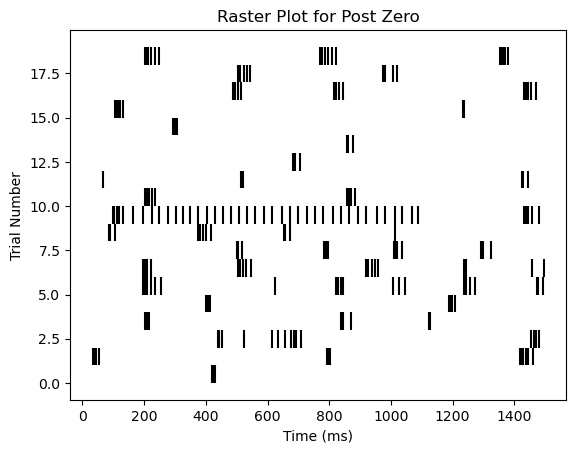

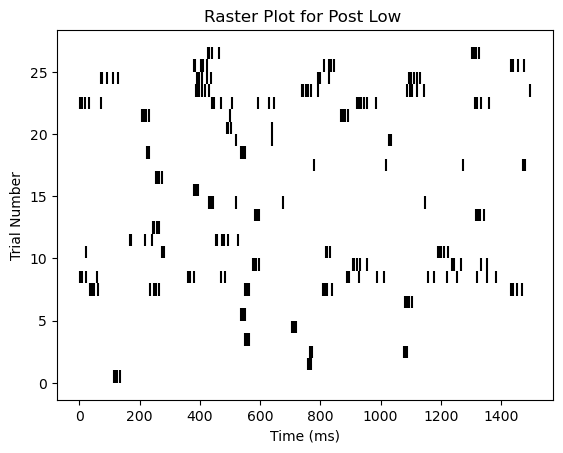

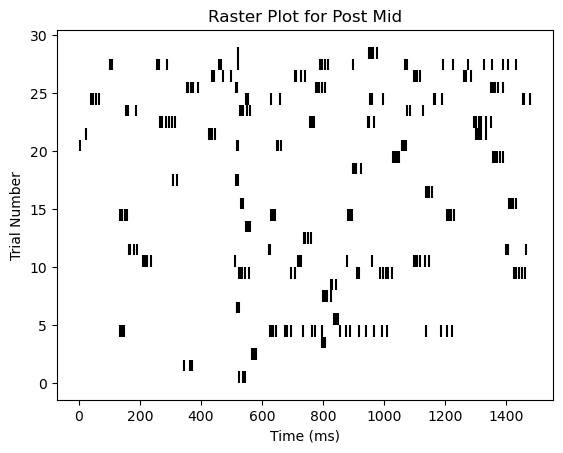

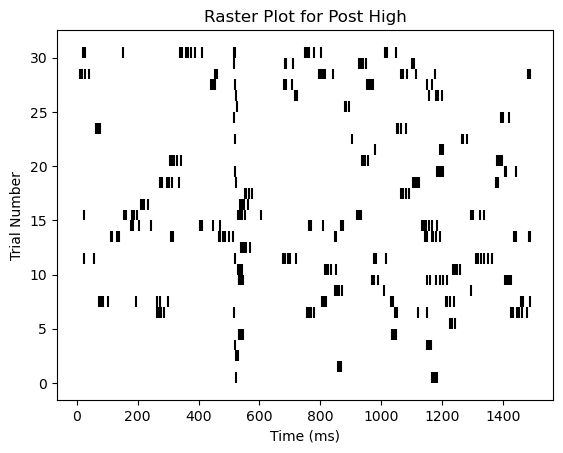

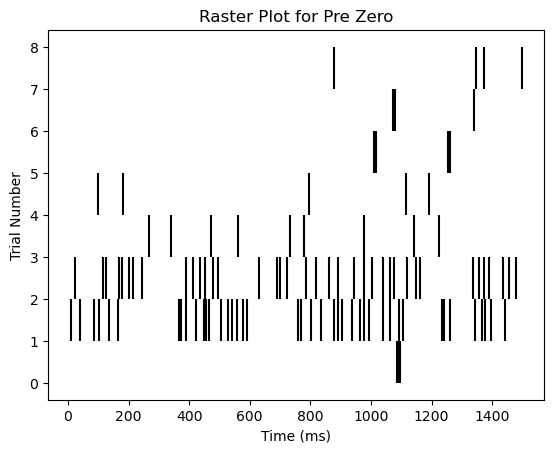

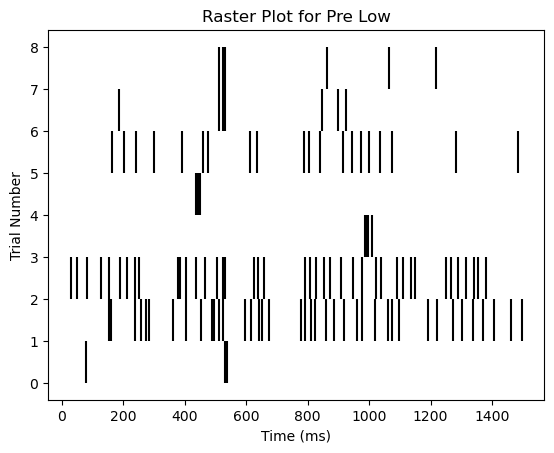

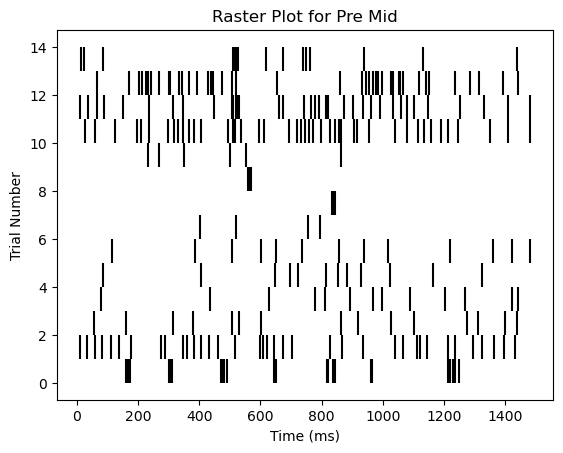

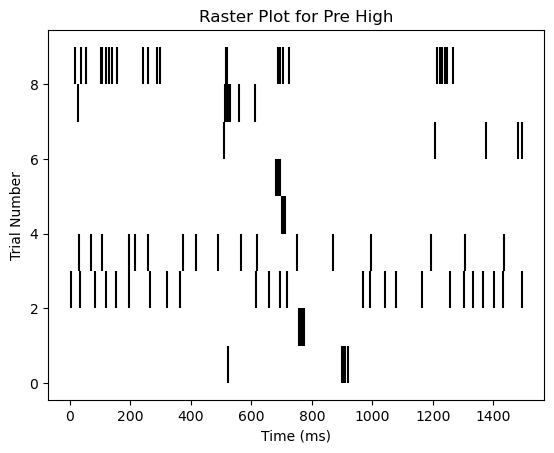

In [223]:
#create a function that will filter the main_df datarame
#take user input for input for true or false for is_post 
#then in a iterative manner, 1) filter the dataframe by zero, low, mid, high 2) filter the dataframe by no_spike being FALSE and more_than_50 being TRUE 3) plot the raster plot for each stimulus as a new plot 
def plot_raster_main_df_no_spike(main_df, is_post):
   #is_post is a boolean value of 1 or 0
   #if is_post is 1, then plot the post stimulus conditions
   #if is_post is 0, then plot the pre stimulus conditions
   #filter the dataframe by is_post being TRUE or FALSE
   if is_post == 1:
      #filter the dataframe by is_post being TRUE
      main_df = main_df[main_df['is_post'] == 1]
      #filter the dataframe per stimulus type which is the TRUE or FALSE value for the zero, low, mid, high columns AND filter the dataframe by no_spike being FALSE and more_than_50 being FALSE conditions
      main_df_zero = main_df[(main_df['zero'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
      main_df_low = main_df[(main_df['low'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
      main_df_mid = main_df[(main_df['mid'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
      main_df_high = main_df[(main_df['high'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]

      #now plot the raster plot for each stimulus type by creating a matrix of the spikes where the rows are the trials and the data is the correspding 'spikes' column of the dataframe
      #plot the raster plot for each stimulus type being zero, low, mid, high based on the TRUE or FALSE for zero, low, mid, high columns of the dataframe
      #plot each raster on a new figure   
      fig, ax = plt.subplots(1, 1)
      for i in range(main_df_zero.shape[0]):
         spike_times = np.where(main_df_zero['spikes'].iloc[i] == 1)[0]
         ax.vlines(spike_times, i, i+1, color='black')
      ax.set_xlabel('Time (ms)')
      ax.set_ylabel('Trial Number') 
      ax.set_title('Raster Plot for Post Zero')

      fig, ax = plt.subplots(1, 1)
      for i in range(main_df_low.shape[0]):
         spike_times = np.where(main_df_low['spikes'].iloc[i] == 1)[0]
         ax.vlines(spike_times, i, i+1, color='black')
      ax.set_xlabel('Time (ms)')
      ax.set_ylabel('Trial Number')
      ax.set_title('Raster Plot for Post Low ')

      fig, ax = plt.subplots(1, 1)
      for i in range(main_df_mid.shape[0]):
         spike_times = np.where(main_df_mid['spikes'].iloc[i] == 1)[0]
         ax.vlines(spike_times, i, i+1, color='black')
      ax.set_xlabel('Time (ms)')
      ax.set_ylabel('Trial Number')
      ax.set_title('Raster Plot for Post Mid')

      fig, ax = plt.subplots(1, 1)
      for i in range(main_df_high.shape[0]):
         spike_times = np.where(main_df_high['spikes'].iloc[i] == 1)[0]
         ax.vlines(spike_times, i, i+1, color='black')
      ax.set_xlabel('Time (ms)')
      ax.set_ylabel('Trial Number')
      ax.set_title('Raster Plot for Post High')   

   else: 
      #filter the dataframe by is_post being FALSE
      main_df = main_df[main_df['is_post'] == 0]
      #filter the dataframe per stimulus type which is the TRUE or FALSE value for the zero, low, mid, high columns AND filter the dataframe by no_spike being FALSE and more_than_50 being FALSE conditions
      main_df_zero = main_df[(main_df['zero'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
      main_df_low = main_df[(main_df['low'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
      main_df_mid = main_df[(main_df['mid'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
      main_df_high = main_df[(main_df['high'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]

      #now plot the raster plot for each stimulus type by creating a matrix of the spikes where the rows are the trials and the data is the correspding 'spikes' column of the dataframe
      #plot the raster plot for each stimulus type being zero, low, mid, high based on the TRUE or FALSE for zero, low, mid, high columns of the dataframe
      #plot each raster on a new figure
      fig, ax = plt.subplots(1, 1)
      for i in range(main_df_zero.shape[0]):
         spike_times = np.where(main_df_zero['spikes'].iloc[i] == 1)[0]
         ax.vlines(spike_times, i, i+1, color='black')
      ax.set_xlabel('Time (ms)')
      ax.set_ylabel('Trial Number')
      ax.set_title('Raster Plot for Pre Zero')
      
      fig, ax = plt.subplots(1, 1)
      for i in range(main_df_low.shape[0]):
         spike_times = np.where(main_df_low['spikes'].iloc[i] == 1)[0]
         ax.vlines(spike_times, i, i+1, color='black')
      ax.set_xlabel('Time (ms)')
      ax.set_ylabel('Trial Number')
      ax.set_title('Raster Plot for Pre Low')
      
      fig, ax = plt.subplots(1, 1)
      for i in range(main_df_mid.shape[0]):
         spike_times = np.where(main_df_mid['spikes'].iloc[i] == 1)[0]
         ax.vlines(spike_times, i, i+1, color='black')
      ax.set_xlabel('Time (ms)') 
      ax.set_ylabel('Trial Number')
      ax.set_title('Raster Plot for Pre Mid')
      
      
      fig, ax = plt.subplots(1, 1)
      for i in range(main_df_high.shape[0]):
         spike_times = np.where(main_df_high['spikes'].iloc[i] == 1)[0]
         ax.vlines(spike_times, i, i+1, color='black')
      ax.set_xlabel('Time (ms)')
      ax.set_ylabel('Trial Number')
      ax.set_title('Raster Plot for Pre High')


      
   plt.show()
   
   return 

#call the function to plot the raster plot for the pre and post stimulus types for filtered dataframes
plot_raster_main_df_no_spike(main_df, 1) 
plot_raster_main_df_no_spike(main_df, 0) 
         
         


In [210]:
import pandas as pd

def calculateISIsfromfiltereddata(main_df, is_post):
    #is_post is a boolean value of 1 or 0
    #if is_post is 1, then plot the post stimulus conditions
    #if is_post is 0, then plot the pre stimulus conditions
    #filter the dataframe by is_post being TRUE or FALSE

    
    if is_post == 1:
        #filter the dataframe by is_post being TRUE
        main_df = main_df[main_df['is_post'] == 1]
        #filter the dataframe per stimulus type which is the TRUE or FALSE value for the zero, low, mid, high columns AND filter the dataframe by no_spike being FALSE and more_than_50 being FALSE conditions
        main_df_zero = main_df[(main_df['zero'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
        main_df_low = main_df[(main_df['low'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
        main_df_mid = main_df[(main_df['mid'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
        main_df_high = main_df[(main_df['high'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
        
        #store the dataframes into a list to iterate through
        main_df_list = [main_df_zero, main_df_low, main_df_mid, main_df_high]
        
        #for each dataframe in the list, add a columns for the ISIs to be stored in
        for df in main_df_list:
            df['ISIs'] = pd.Series(dtype=object)
            
        #iterate through the list of dataframes to do the following:
        # 1) create an array for the calculated  ISIs to be stored in for each trial which correspond to the row of the partiuclar dataframe
        # 2) iterate through the spikes column for the length of rows of the particualr  dataframe to calculate the ISIs for each trial
        
        for df in main_df_list:
            for i in range(df.shape[0]):
                ISIs = []
                spike_times = np.where(df['spikes'].iloc[i] == 1)[0]
                for j in range(len(spike_times)-1):
                    ISI = spike_times[j+1] - spike_times[j]
                    ISIs.append(ISI)
                df['ISIs'].iloc[i] = ISIs
                
    #else if is_post is 0, repeate the same process as above but for the pre stimulus conditions
    elif is_post == 0:
        main_df = main_df[main_df['is_post'] == 0]
        main_df_zero = main_df[(main_df['zero'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
        main_df_low = main_df[(main_df['low'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
        main_df_mid = main_df[(main_df['mid'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
        main_df_high = main_df[(main_df['high'] == 1) & (main_df['more_than_2'] == 1) & (main_df['more_than_50'] == 0)]
        
        main_df_list = [main_df_zero, main_df_low, main_df_mid, main_df_high]
        
        #for each dataframe in the list, add a columns for the ISIs to be stored in
        for df in main_df_list:
            df['ISIs'] = pd.Series(dtype=object)
            
        #iterate through the list of dataframes to do the following:
        # 1) create an array for the calculated  ISIs to be stored in for each trial which correspond to the row of the partiuclar dataframe
        # 2) iterate through the spikes column for the length of rows of the particualr  dataframe to calculate the ISIs for each trial
        
        for df in main_df_list:
            for i in range(df.shape[0]):
                ISIs = []
                spike_times = np.where(df['spikes'].iloc[i] == 1)[0]
                for j in range(len(spike_times)-1):
                    ISI = spike_times[j+1] - spike_times[j]
                    ISIs.append(ISI)
                df['ISIs'].iloc[i] = ISIs
                
                    
    #retunn the updated list of dataframes once processed
    return main_df_list

#call the function to calculate the ISIs for the post stimulus conditions
main_df_list_post = calculateISIsfromfiltereddata(main_df, 1)

#call the function to calculate the ISIs for the pre stimulus conditions
main_df_list_pre = calculateISIsfromfiltereddata(main_df, 0)





/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/583191335.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ISIs'] = pd.Series(dtype=object)
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/583191335.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ISIs'] = pd.Series(dtype=object)
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/583191335.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

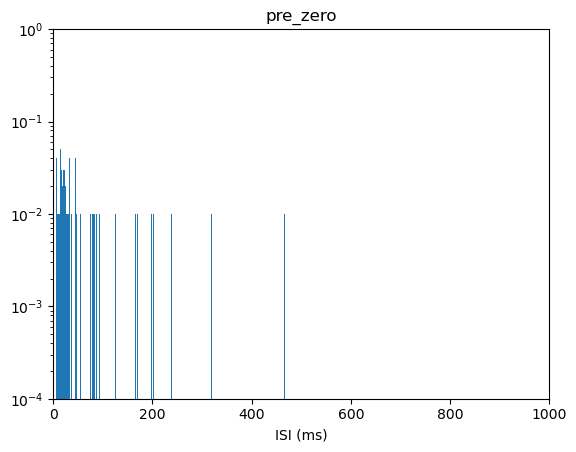

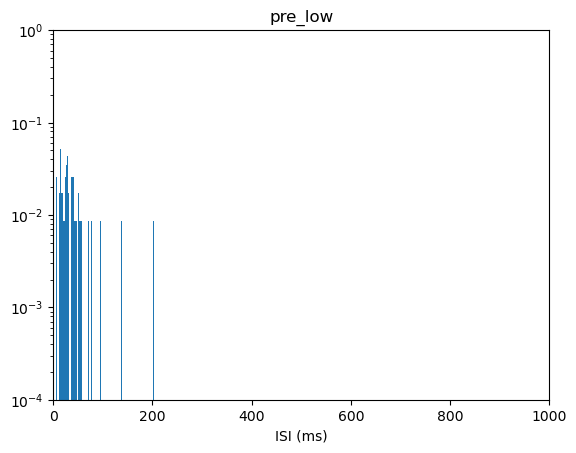

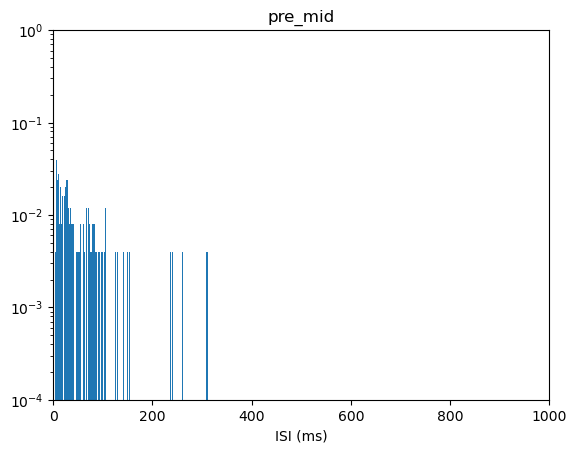

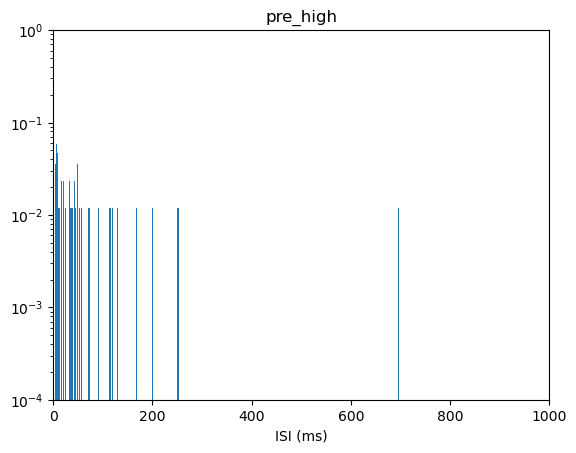

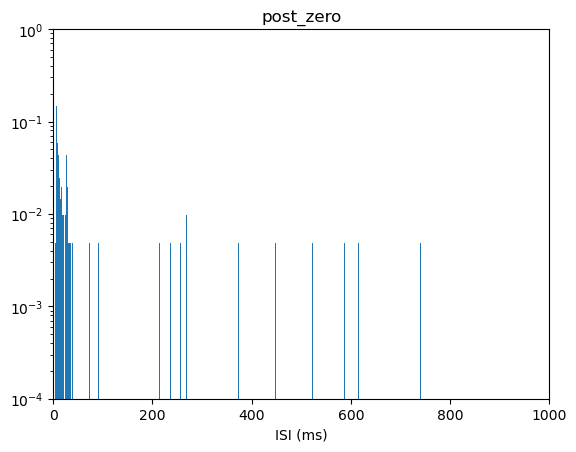

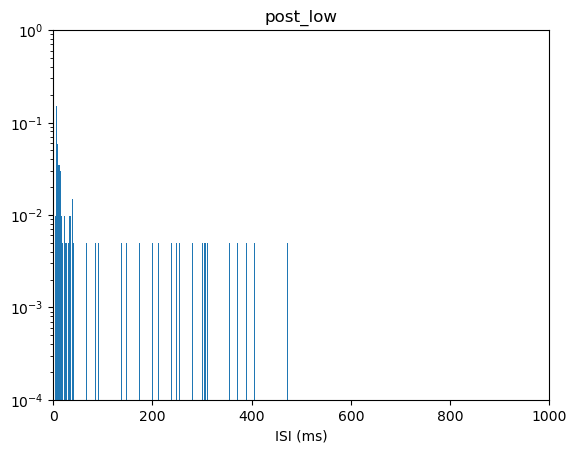

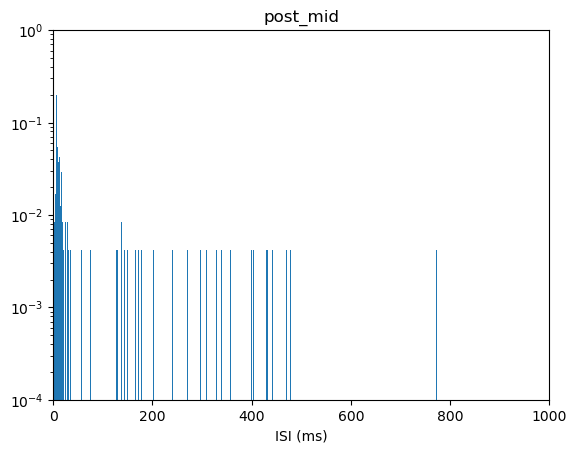

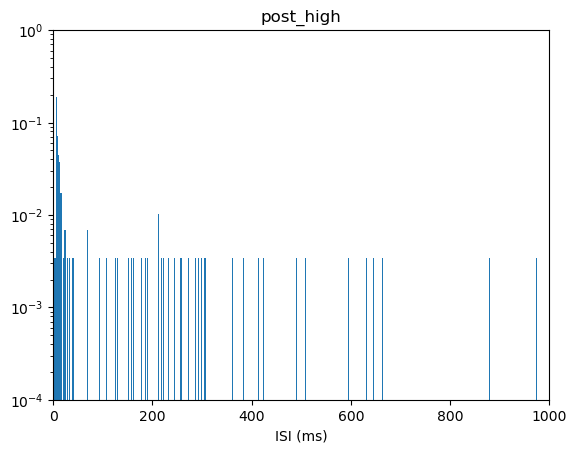

In [219]:
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde


#create a funnction to plot the histogram of the ISIs using the list of dataframes given to the function as an input 
def plotISIhistogram(main_df_list):
    #iterate through the list of dataframes to plot the histogram of the ISIs for each stimulus type on a separate plot
    for df in main_df_list:
        #store all ISIs into a list for plotting and peform a log transformation on the ISIs
        all_ISIs = []       
        
        #iniatilize the bin_size=25 for the histogram, ##CHANGE HERE FOR BIN SIZE was 25
        bin_size = 1
        
        for i in range(df.shape[0]):
            for j in range(len(df['ISIs'].iloc[i])):
                all_ISIs.append(df['ISIs'].iloc[i][j])
                
                #of the 
                


        
        #plot the histogram of the ISIs overlaid with the gaussian kernel density estimate
        plt.hist(all_ISIs, bins=np.arange(0, max(all_ISIs) + bin_size, bin_size), density=True)
        

        
        
        #log scale the y axis
        plt.yscale('log')
        #set the the upper limit of the y axis to be 1
        
        #set the x axis to be 1500ms ###CHANGE HERE TO ZOOM
        plt.xlim(0, 1000)
        
        plt.ylim(0.0001, 1)    

        #set the x axis label
        plt.xlabel('ISI (ms)')
        
        #set the title to be the column called 'trial_name' in the dataframe
        plt.title(df['trial_name'].iloc[0])

        #show the plot
        plt.show()
            
        


#call the function to plot the histogram of the ISIs for the pre stimulus conditions
plotISIhistogram(main_df_list_pre)

#call the function to plot the histogram of the ISIs for the post stimulus conditions   
plotISIhistogram(main_df_list_post)
        
        
        
        
                    



In [ ]:
# now repeat the same process as above but zoom in on the ISIs between 0 and 100ms  
def plotISIhistogramzoomed(main_df_list):
    #iterate through the list of dataframes to plot the histogram of the ISIs for each stimulus type on a separate plot
    for df in main_df_list:
        
        
    
    

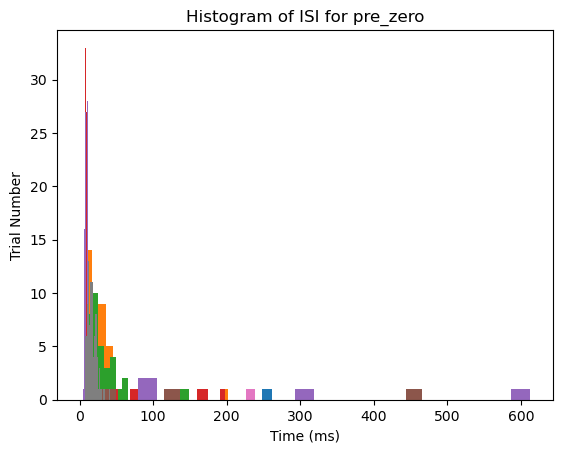

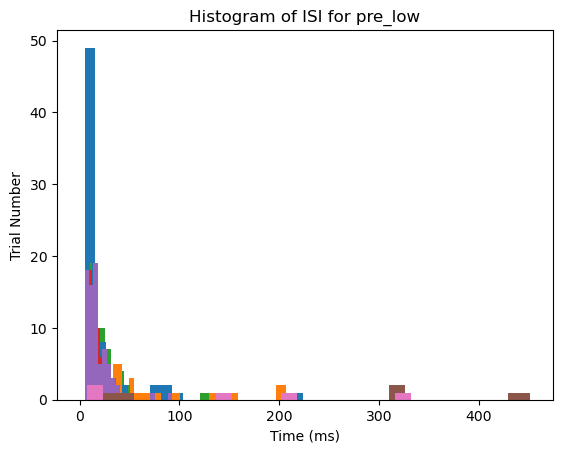

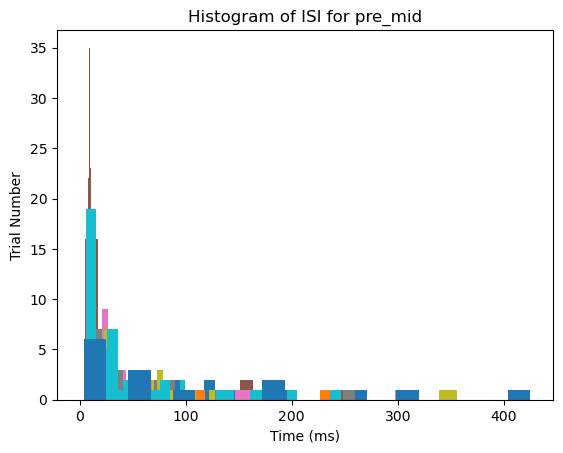

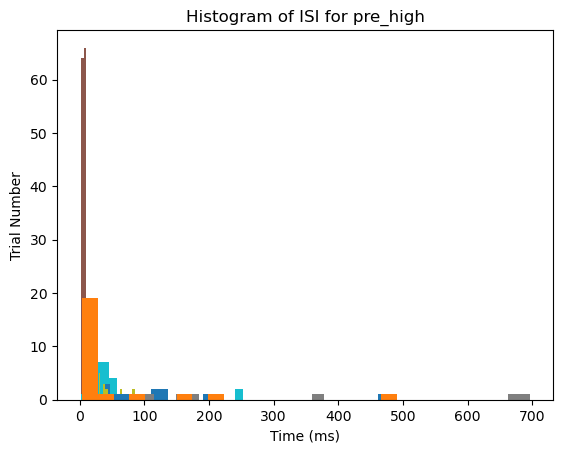

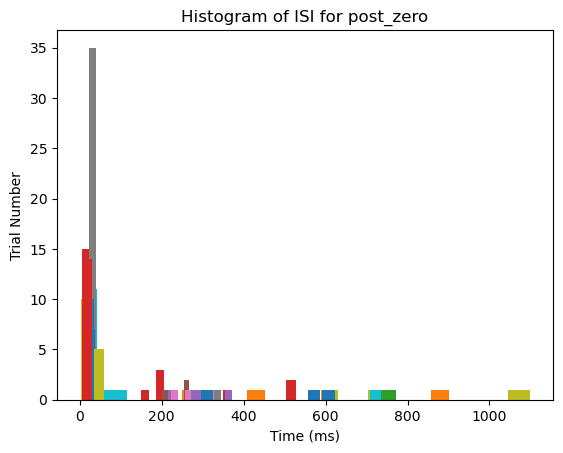

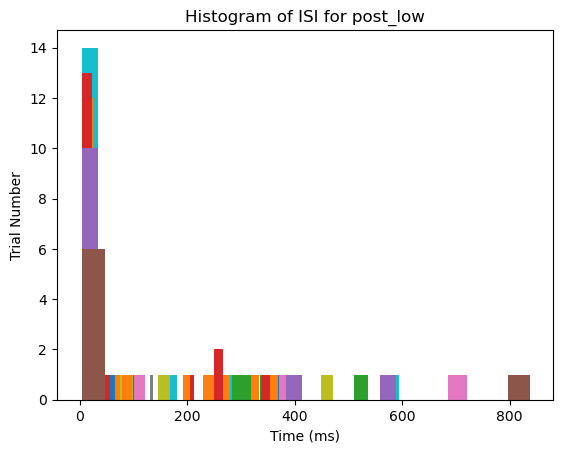

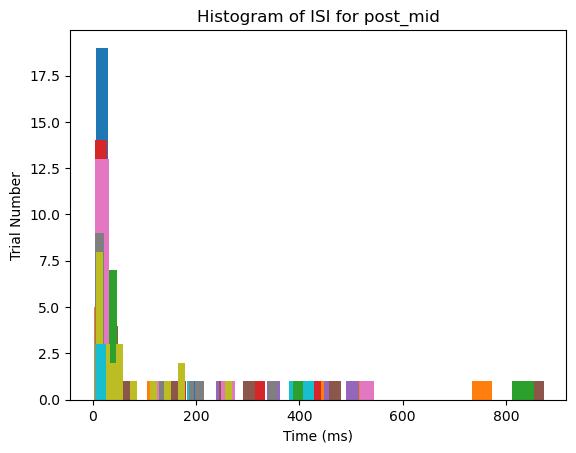

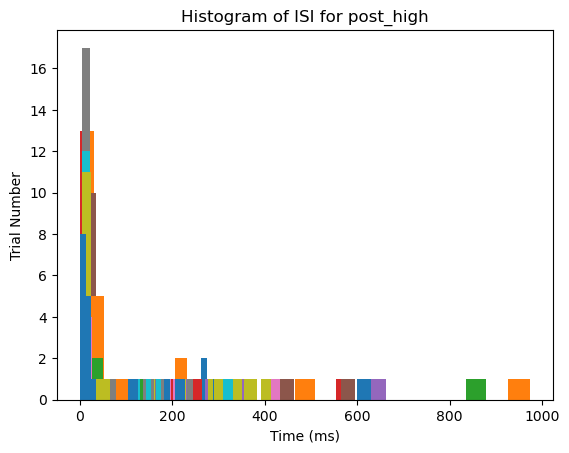

In [28]:
#now calculate the ISI for each spike train and plot the histogram of the ISI for each spike train
for key in spiketrains_dict:
    spikes = spiketrains_dict[key]
    fig, ax = plt.subplots(1, 1)
    for i in range(spikes.shape[0]):
        spike_times = np.where(spikes[i] == 1)[0]
        ISI = np.diff(spike_times)
        ax.hist(ISI, bins=20)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Trial Number')
    ax.set_title('Histogram of ISI for ' + key)
    plt.show()

In [29]:
#now create a list of matrices for the pre and post stimulus conditions in two different lists and each matrix is a list of the spike times for each stimulus condition zero, low, mid, high
pre_stimulus_list = []
post_stimulus_list = []
for key in spiketrains_dict:
    if key.startswith('pre'):
        pre_stimulus_list.append(spiketrains_dict[key])
    else:
        post_stimulus_list.append(spiketrains_dict[key])
        



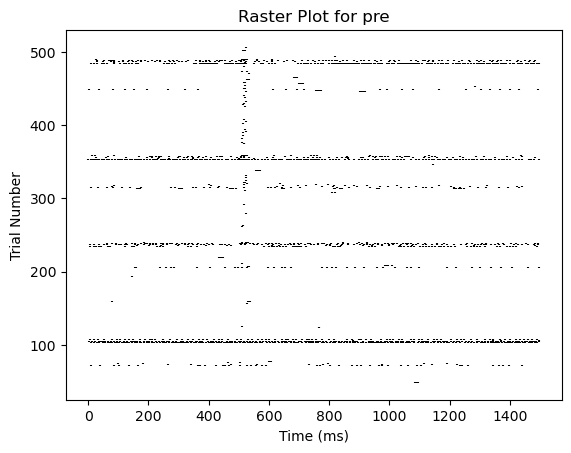

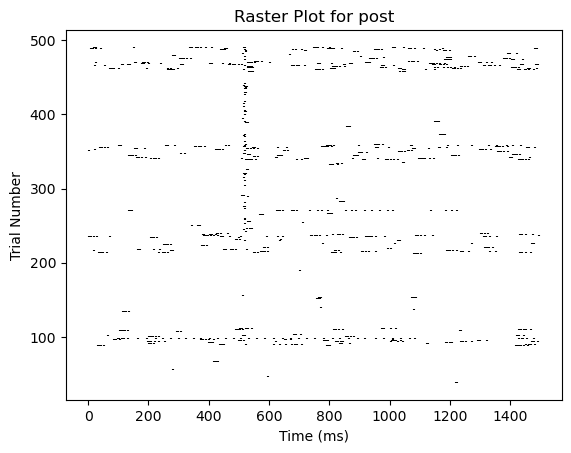

In [30]:
#now combine the pre matrices into one matrix and the post matrices into one matrix based on the keys names in the spiketrains_dict
#rename the keys in the spiketrains_dict to be pre and post
spiketrains_dict['pre'] = spiketrains_dict.pop('pre_zero')
spiketrains_dict['pre'] = np.vstack((spiketrains_dict['pre'], spiketrains_dict.pop('pre_low')))
spiketrains_dict['pre'] = np.vstack((spiketrains_dict['pre'], spiketrains_dict.pop('pre_mid')))
spiketrains_dict['pre'] = np.vstack((spiketrains_dict['pre'], spiketrains_dict.pop('pre_high')))
spiketrains_dict['post'] = spiketrains_dict.pop('post_zero')
spiketrains_dict['post'] = np.vstack((spiketrains_dict['post'], spiketrains_dict.pop('post_low')))
spiketrains_dict['post'] = np.vstack((spiketrains_dict['post'], spiketrains_dict.pop('post_mid')))
spiketrains_dict['post'] = np.vstack((spiketrains_dict['post'], spiketrains_dict.pop('post_high')))


#now plot the raster plot for the pre and post stimulus conditions
for key in spiketrains_dict:
    spikes = spiketrains_dict[key]
    fig, ax = plt.subplots(1, 1)
    for i in range(spikes.shape[0]):
        spike_times = np.where(spikes[i] == 1)[0]
        ax.vlines(spike_times, i, i+1, color='black')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Trial Number')
    ax.set_title('Raster Plot for ' + key)
    plt.show()
    
    

/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/3140422678.py:58: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ISI, hist=False, color='grey')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/3140422678.py:58: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn

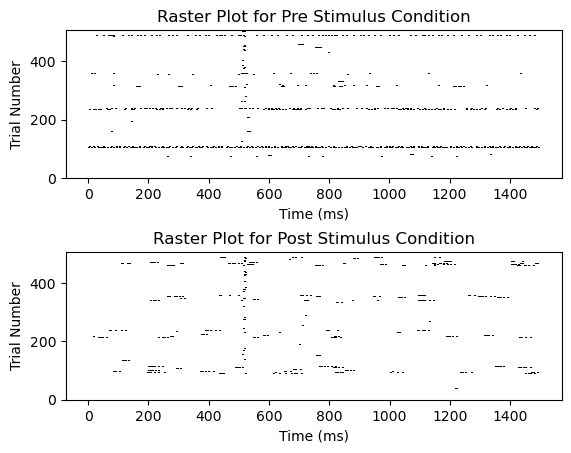

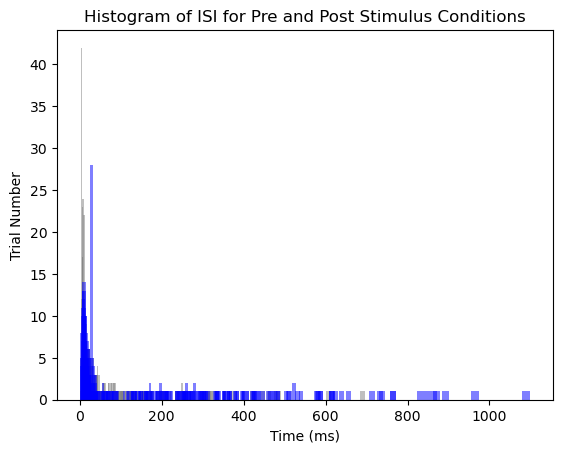

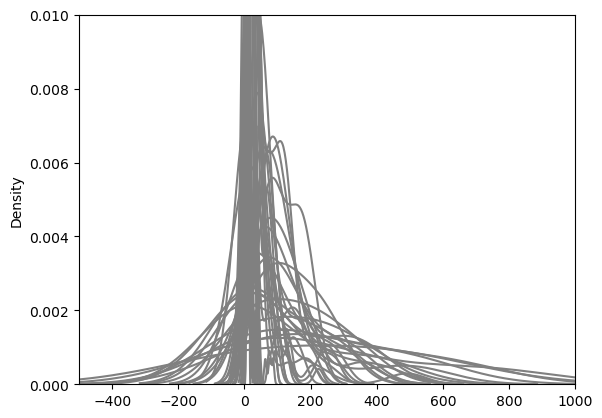

In [31]:
#create a matrix called pre_matrix annd post_matrix from the spiketrains_dict
pre_matrix = spiketrains_dict['pre']
post_matrix = spiketrains_dict['post']

#now create a subplot with 2 rows and 1 column
#using the pre_matrix and post_matrix, plot the raster plots for the pre and post stimulus conditions
fig, ax = plt.subplots(2, 1)
for i in range(pre_matrix.shape[0]):
    spike_times = np.where(pre_matrix[i] == 1)[0]
    ax[0].vlines(spike_times, i, i+1, color='black')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Trial Number')
ax[0].set_title('Raster Plot for Pre Stimulus Condition')

for i in range(post_matrix.shape[0]):
    spike_times = np.where(post_matrix[i] == 1)[0]
    ax[1].vlines(spike_times, i, i+1, color='black')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Trial Number')
ax[1].set_title('Raster Plot for Post Stimulus Condition')

#create more spave between the two plots and keep both y axes the same which ever is larger

#find the max y value for the pre and post stimulus conditions
pre_max_y = pre_matrix.shape[0]
post_max_y = post_matrix.shape[0]

#set the y limits for both plots to be the max y value
ax[0].set_ylim(0, max(pre_max_y, post_max_y))
ax[1].set_ylim(0, max(pre_max_y, post_max_y))

#set the space between the two plots to be 0.5

fig.subplots_adjust(hspace=0.5)

#now plot the ISI for the pre and post stimulus conditions 
#pre stimulus condition is in blue and post stimulus condition is in red
fig, ax = plt.subplots(1, 1)
for i in range(pre_matrix.shape[0]):
    spike_times = np.where(pre_matrix[i] == 1)[0]
    ISI = np.diff(spike_times)
    ax.hist(ISI, bins=50, color='grey', alpha=0.5)
for i in range(post_matrix.shape[0]):
    spike_times = np.where(post_matrix[i] == 1)[0]
    ISI = np.diff(spike_times)
    ax.hist(ISI, bins=50, color='blue', alpha=0.5)
    
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Trial Number')
ax.set_title('Histogram of ISI for Pre and Post Stimulus Conditions')

#now create a smpoothed histogram of the ISI for the pre and post stimulus conditions
#pre stimulus condition is in blue and post stimulus condition is in red
fig, ax = plt.subplots(1, 1)
for i in range(pre_matrix.shape[0]):
    spike_times = np.where(pre_matrix[i] == 1)[0]
    ISI = np.diff(spike_times)
    sns.distplot(ISI, hist=False, color='grey')
    #zoom in on the y axis to see the distribution better
    ax.set_ylim(0, 0.01)
    ax.set_xlim(-500, 1000)

/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/1644054096.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ISI, hist=False, color='blue')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/1644054096.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

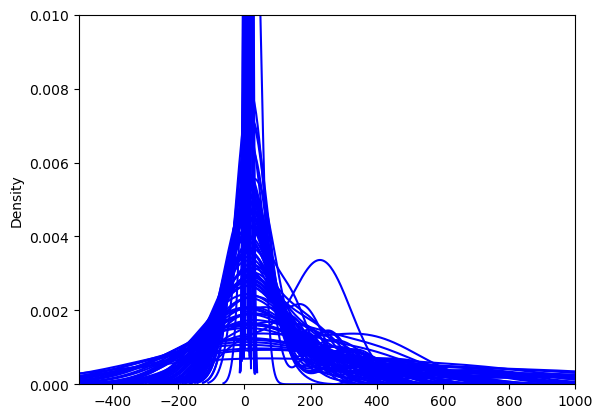

In [32]:
#now create a smpoothed histogram of the ISI for the post stimulus conditions
#post stimulus condition is in blue
fig, ax = plt.subplots(1, 1)
for i in range(post_matrix.shape[0]):
    spike_times = np.where(post_matrix[i] == 1)[0]
    ISI = np.diff(spike_times)
    sns.distplot(ISI, hist=False, color='blue')
    #zoom in on the y axis to see the distribution better
    ax.set_ylim(0, 0.01)
    ax.set_xlim(-500, 1000)
    

/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/2806755073.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ISI, color='grey')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/2806755073.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ISI, color='grey')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/2806755073.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ISI, color='grey')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/2806755073.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ISI, color='grey')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/2806755073.

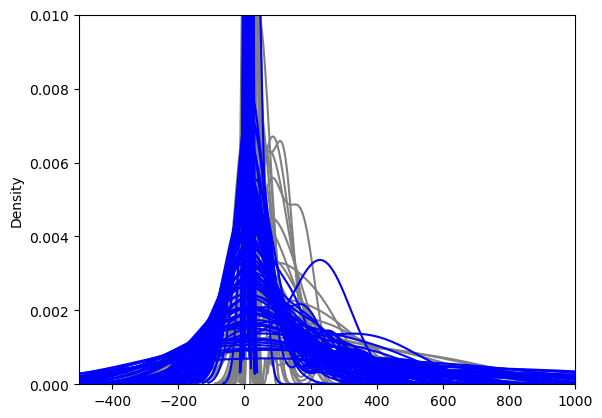

In [33]:
#gaussian kernel density estimation
#now create a smpoothed histogram of the ISI for the pre and post stimulus conditions
#pre stimulus condition is in grey and post stimulus condition is in blue
fig, ax = plt.subplots(1, 1)
for i in range(pre_matrix.shape[0]):
    spike_times = np.where(pre_matrix[i] == 1)[0]
    ISI = np.diff(spike_times)
    sns.kdeplot(ISI, color='grey')
    #zoom in on the y axis to see the distribution better
    ax.set_ylim(0, 0.01)
    ax.set_xlim(-500, 1000)
    
for i in range(post_matrix.shape[0]):
    spike_times = np.where(post_matrix[i] == 1)[0]
    ISI = np.diff(spike_times)
    sns.kdeplot(ISI, color='blue')
    #zoom in on the y axis to see the distribution better
    ax.set_ylim(0, 0.01)
    ax.set_xlim(-500, 1000)
    
    

/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/420898397.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ISI, color='grey')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/420898397.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ISI, color='grey')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/420898397.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ISI, color='grey')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/420898397.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ISI, color='grey')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_72143/420898397.py:8:

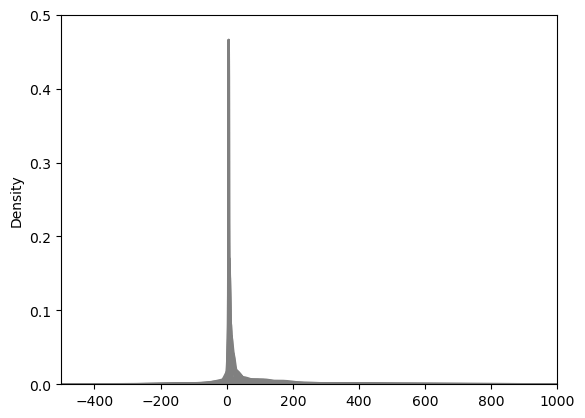

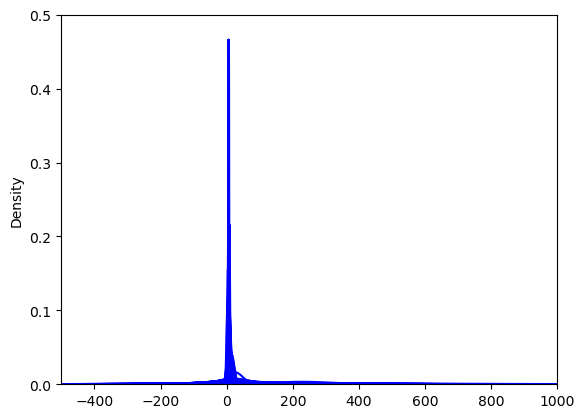

In [34]:
#gaussian kernel density estimation
#now create a smpoothed histogram of the ISI for the pre and post stimulus conditions
#pre stimulus condition is in grey and post stimulus condition is in blue
fig, ax = plt.subplots(1, 1)
for i in range(pre_matrix.shape[0]):
    spike_times = np.where(pre_matrix[i] == 1)[0]
    ISI = np.diff(spike_times)
    sns.kdeplot(ISI, color='grey')
    ax.set_ylim(0, 0.5)
    ax.set_xlim(-500, 1000)
    
fig, ax = plt.subplots(1, 1)
for i in range(post_matrix.shape[0]):
    spike_times = np.where(post_matrix[i] == 1)[0]
    ISI = np.diff(spike_times)
    sns.kdeplot(ISI, color='blue')
    ax.set_ylim(0, 0.5)
    ax.set_xlim(-500, 1000)



/Users/cresp1el/anaconda3/envs/lmc_ephys_pipeline/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/cresp1el/anaconda3/envs/lmc_ephys_pipeline/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


(0.0, 0.1)

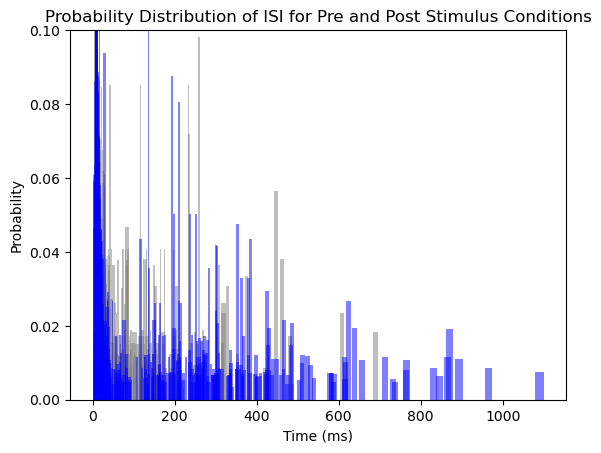

In [36]:
#calculate the probability distribution of the ISIs for the pre and post stimulus conditions
#pre stimulus condition is in grey and post stimulus condition is in blue
fig, ax = plt.subplots(1, 1)
for i in range(pre_matrix.shape[0]):
    spike_times = np.where(pre_matrix[i] == 1)[0]
    ISI = np.diff(spike_times)
    ax.hist(ISI, bins=50, density=True, color='grey', alpha=0.5)
for i in range(post_matrix.shape[0]):
    spike_times = np.where(post_matrix[i] == 1)[0]
    ISI = np.diff(spike_times)
    ax.hist(ISI, bins=50, density=True, color='blue', alpha=0.5)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Probability')
ax.set_title('Probability Distribution of ISI for Pre and Post Stimulus Conditions')

#zoom in on the y axis to see the distribution better
ax.set_ylim(0, 0.1)

In [ ]:
#create a function that 